In [1]:
import gym
import random
import numpy as np
import tensorflow as tf

from collections import deque

from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)
random.seed(seed)

# DQN Agent

In [2]:
class DQNAgent:
    def __init__(self, obs_dim, n_action, seed=0,
                 discount_factor = 0.995, epsilon_decay = 0.999, epsilon_min = 0.01,
                 learning_rate = 1e-3, # Step size for Adam
                 batch_size = 64, 
                 memory_size = 2000, hidden_unit_size = 64):
        
        self.seed = seed 
        
        # Environment Information
        self.obs_dim = obs_dim
        self.n_action = n_action
        self.discount_factor = discount_factor
        
        # Epsilon Greedy Policy
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Network Hyperparameters
        self.hidden_unit_size = hidden_unit_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_start = 1000

        # Experience Replay
        self.memory = deque(maxlen=memory_size)
        
        # Define Computational Graph in TF
        self.g = tf.Graph()
        with self.g.as_default():
            self.build_placeholders()
            self.build_model()
            self.build_loss()
            self.build_update_operation()
            self.init_session() # Initialize all parameters in graph
    
    def build_placeholders(self): # Build input and output place holder
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs') # Input state
        self.target_ph = tf.placeholder(tf.float32, (None, self.n_action), 'target') # TD target
        self.learning_rate_ph = tf.placeholder(tf.float32, (), 'lr')        
    
    def build_model(self): # Build networks
        hid1_size = self.hidden_unit_size
        hid2_size = self.hidden_unit_size
        
        with tf.variable_scope('q_prediction'): # Prediction Network / Two layered perceptron / Training Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
                        
        with tf.variable_scope('q_target'): # Target Network / Two layered perceptron / Old Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict_old = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
        
        self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction') # Get Prediction network's Parameters
        self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target') # Get Target network's Parameters

    def build_loss(self):
        self.loss = 0.5*tf.reduce_mean(tf.square(self.target_ph - self.q_predict)) # Squared Error
        self.optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph).minimize(self.loss) # AdamOptimizer (Gradient Descent Algorithm)
            
    def build_update_operation(self): # Define parameter update operation in TF graph
        update_ops = [] 
        for var, var_old in zip(self.weights, self.weights_old): # Update Target Network's Parameter with Prediction Network
            update_ops.append(var_old.assign(var))
        self.update_ops = update_ops
        
    def init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g) # Initialize session
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.update_ops)
        
    def update_target(self): # Update parameters
        self.sess.run(self.update_ops)
        
    def update_policy(self):
        if self.epsilon > self.epsilon_min: # Update epsilon
            self.epsilon *= self.epsilon_decay
        
    def get_prediction_old(self, obs): # Get Q value from target network
        q_value_old = self.sess.run(self.q_predict_old,feed_dict={self.obs_ph:obs})        
        return q_value_old
        
    def get_prediction(self, obs): # Get Q value from prediction network
        q_value = self.sess.run(self.q_predict,feed_dict={self.obs_ph:obs})        
        return q_value
    
    def get_action(self, obs): # Epsilon Greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_action)
        else:
            q_value = self.get_prediction([obs])
            return np.argmax(q_value[0])

    def add_experience(self, obs, action, reward, next_obs, done): # Add experience to memory
        self.memory.append((obs, action, reward, next_obs, done))

    def train_model(self):
        loss = np.nan
        n_entries = len(self.memory)
            
        if n_entries > self.train_start: # Start training when the number of experience is greater than batch size
            
            # Randomly sample batch
            mini_batch = random.sample(self.memory, self.batch_size)
            
            observations = np.zeros((self.batch_size, self.obs_dim))
            next_observations = np.zeros((self.batch_size, self.obs_dim))
            actions, rewards, dones = [], [], []

            for i in range(self.batch_size):
                observations[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                next_observations[i] = mini_batch[i][3]
                dones.append(mini_batch[i][4])

            target = self.get_prediction(observations)
            next_q_value = self.get_prediction_old(next_observations)

            # BELLMAN UPDATE RULE 
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(next_q_value[i]))

            loss, _ = self.sess.run([self.loss, self.optim], 
                                 feed_dict={self.obs_ph:observations,self.target_ph:target,self.learning_rate_ph:self.learning_rate})                        
        return loss

# Environment

In [3]:
env = gym.make('CartPole-v1')
obs_space = env.observation_space
print('Observation space')
print(type(obs_space))
print(obs_space.shape)
print("Dimension:{}".format(obs_space.shape[0]))
print("High: {}".format(obs_space.high))
print("Low: {}".format(obs_space.low))
print()

act_space = env.action_space
print('Action space')
print(type(act_space))
print("Total {} actions".format(act_space.n))
print()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation space
<class 'gym.spaces.box.Box'>
(4,)
Dimension:4
High: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]

Action space
<class 'gym.spaces.discrete.Discrete'>
Total 2 actions



# Train Expert

In [4]:
env.seed(seed)
max_t = env.spec.max_episode_steps
expert = DQNAgent(env.observation_space.high.shape[0],env.action_space.n)

avg_return_list = []
avg_return = deque(maxlen=10)
avg_loss = deque(maxlen=10)
nepisodes = 1000
for i in range(nepisodes+1):
    obs = env.reset()
    done = False
    total_reward = 0
    total_loss = 0
    for t in range(max_t):
        # Get transition
        action = expert.get_action(obs)
        next_obs, reward, done, info = env.step(action)

        # Add experience
        expert.add_experience(obs,action,reward,next_obs,done)

        # Online update perdiction network parameter
        loss = expert.train_model()

        obs = next_obs
        total_reward += reward
        total_loss += loss

        if done:
            break

        # Update target network parameter
        expert.update_target()
        expert.update_policy()

    avg_return.append(total_reward)
    avg_loss.append(total_loss)
    avg_return_list.append(np.mean(avg_return))

    if (np.mean(avg_return) > 490): # Threshold return to success cartpole

        print('[{}/{}] loss : {:.3f}, return : {:.3f}'.format(i,nepisodes, np.mean(avg_loss), np.mean(avg_return)))
        print('The problem is solved with {} episodes'.format(i))
        break

    if (i%100)==0:
        print('[{}/{}] loss : {:.3f}, return : {:.3f}'.format(i,nepisodes, np.mean(avg_loss), np.mean(avg_return)))

dqn_return_list = avg_return_list

[0/1000] loss : nan, return : 11.000
[100/1000] loss : 55.819, return : 10.300
[200/1000] loss : 1341.734, return : 101.100
[300/1000] loss : 271.446, return : 14.600
[400/1000] loss : 3873.282, return : 117.600
[487/1000] loss : 5254.369, return : 500.000
The problem is solved with 487 episodes


# Deep Q Learning from Demonstrations

In [5]:
class DQNfDAgent:
    def __init__(self, obs_dim, n_action, seed=0,
                 discount_factor = 0.995, epsilon_decay = 0.999, epsilon_min = 0.01,
                 learning_rate = 1e-3, # Step size for Adam
                 batch_size = 64, 
                 memory_size = 2000, hidden_unit_size = 64):
        
        self.seed = seed 
        
        # Environment Information
        self.obs_dim = obs_dim
        self.n_action = n_action
        self.discount_factor = discount_factor
        
        # Epsilon Greedy Policy
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Network Hyperparameters
        self.hidden_unit_size = hidden_unit_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.train_start = 1000

        # Experience Replay
        self.memory = deque(maxlen=memory_size)
        
        # Define Computational Graph in TF
        self.g = tf.Graph()
        with self.g.as_default():
            self.build_placeholders()
            self.build_model()
            self.build_loss()
            self.build_update_operation()
            self.init_session() # Initialize all parameters in graph
    
    def build_placeholders(self): # Build input and output place holder
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs') # Input state
        self.target_ph = tf.placeholder(tf.float32, (None, self.n_action), 'target') # TD target
        self.isdemo_ph = tf.placeholder(tf.float32,(None, ), name="isdemo") # Flag : Expert = 1, Non expert = 0
        self.action_batch = tf.placeholder(tf.int32, (None, ), name="action_batch")
        self.learning_rate_ph = tf.placeholder(tf.float32, (), 'lr')        
    
    def build_model(self): # Build networks
        hid1_size = self.hidden_unit_size
        hid2_size = self.hidden_unit_size
        
        with tf.variable_scope('q_prediction'): # Prediction Network / Two layered perceptron / Training Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
                        
        with tf.variable_scope('q_target'): # Target Network / Two layered perceptron / Old Parameters
            out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden1')
            out = tf.layers.dense(out, hid2_size, tf.tanh, # Tangent Hyperbolic Activation
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='hidden2')
            self.q_predict_old = tf.layers.dense(out, self.n_action, # Linear Layer
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='q_predict')
        
        self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction') # Get Prediction network's Parameters
        self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target') # Get Target network's Parameters

    def build_loss(self):
        def loss_l(ae, a): # Action mismatch loss
            return 0.0 if ae == a else 0.8

        def loss_jeq(Q_predict): # Large Margin Loss for expert's demo
            jeq = 0.0
            for i in range(self.batch_size):
                ae = self.action_batch[i]
                max_value = float("-inf")
                for a in range(self.n_action):
                    max_value = tf.maximum(Q_predict[i][a] + loss_l(ae, a), max_value)
                jeq += self.isdemo_ph[i] * (max_value - Q_predict[i][ae])
            return jeq
        
        self.loss_jeq = loss_jeq(self.q_predict) # Expert's Loss
        self.loss_dq = 0.5*tf.reduce_mean(tf.square(self.target_ph - self.q_predict))
        self.loss = self.loss_dq + self.loss_jeq
        self.optim = tf.train.AdamOptimizer(learning_rate=self.learning_rate_ph).minimize(self.loss) # AdamOptimizer (Gradient Descent Algorithm)
            
    def build_update_operation(self): # Define parameter update operation in TF graph
        update_ops = [] 
        for var, var_old in zip(self.weights, self.weights_old): # Update Target Network's Parameter with Prediction Network
            update_ops.append(var_old.assign(var))
        self.update_ops = update_ops
        
    def init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g) # Initialize session
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.update_ops)
        
    def update_target(self): # Update parameters
        self.sess.run(self.update_ops)
        
    def update_policy(self):
        if self.epsilon > self.epsilon_min: # Update epsilon
            self.epsilon *= self.epsilon_decay
        
    def get_prediction_old(self, obs): # Get Q value from target network
        q_value_old = self.sess.run(self.q_predict_old,feed_dict={self.obs_ph:obs})        
        return q_value_old
        
    def get_prediction(self, obs): # Get Q value from prediction network
        q_value = self.sess.run(self.q_predict,feed_dict={self.obs_ph:obs})        
        return q_value
    
    def get_action(self, obs): # Epsilon Greedy policy
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_action)
        else:
            q_value = self.get_prediction([obs])
            return np.argmax(q_value[0])

    def add_experience(self, obs, action, reward, next_obs, done, isdemo=False): # Add experience to memory
        self.memory.append((obs, action, reward, next_obs, done, isdemo)) # Now, demo flag is stored

    def train_model(self):
        loss = np.nan
        n_entries = len(self.memory)
            
        if n_entries > self.train_start: # Start training when the number of experience is greater than batch size
            
            # Randomly sample batch
            mini_batch = random.sample(self.memory, self.batch_size)
            
            observations = np.zeros((self.batch_size, self.obs_dim))
            next_observations = np.zeros((self.batch_size, self.obs_dim))
            actions, rewards, dones, isdemo = [], [], [], []

            for i in range(self.batch_size):
                observations[i] = mini_batch[i][0]
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                next_observations[i] = mini_batch[i][3]
                dones.append(mini_batch[i][4])
                isdemo.append(mini_batch[i][5])

            target = self.get_prediction(observations)
            next_q_value = self.get_prediction_old(next_observations)

            # BELLMAN UPDATE RULE 
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(next_q_value[i]))

            loss, _ = self.sess.run([self.loss, self.optim], 
                                 feed_dict={self.obs_ph:observations,self.target_ph:target,self.learning_rate_ph:self.learning_rate,self.isdemo_ph:isdemo,self.action_batch:actions})                        
        return loss

# Collect Demonstrations

In [6]:
agent = DQNfDAgent(env.observation_space.high.shape[0],env.action_space.n)
ndemos = 10
experts_return = deque(maxlen=ndemos)
for i in range(ndemos+1):
    obs = env.reset()
    done = False
    total_reward = 0
    total_loss = 0
    for t in range(max_t):
        # Get transition
        action = expert.get_action(obs)
        next_obs, reward, done, info = env.step(action)

        # Add experience
        agent.add_experience(obs,action,reward,next_obs,done,isdemo=True)

        # Online update perdiction network parameter
        loss = agent.train_model()

        obs = next_obs
        total_reward += reward
        total_loss += loss

        if done:
            break
    experts_return.append(total_reward)

print("Expert's Performance : %.02f"%np.mean(experts_return))

Expert's Performance : 500.00


# Train DQNfD

In [7]:
avg_return_list = []
avg_return = deque(maxlen=10)
avg_loss = deque(maxlen=10)
nepisodes = 1000
for i in range(nepisodes+1):
    obs = env.reset()
    done = False
    total_reward = 0
    total_loss = 0
    for t in range(max_t):
        # Get transition
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)

        # Add experience
        agent.add_experience(obs,action,reward,next_obs,done,isdemo=False)

        # Online update perdiction network parameter
        loss = agent.train_model()

        obs = next_obs
        total_reward += reward
        total_loss += loss

        if done:
            break

        # Update target network parameter
        agent.update_target()
        agent.update_policy()

    avg_return.append(total_reward)
    avg_loss.append(total_loss)
    avg_return_list.append(np.mean(avg_return))

    if (np.mean(avg_return) > 490): # Threshold return to success cartpole

        print('[{}/{}] loss : {:.3f}, return : {:.3f}'.format(i,nepisodes, np.mean(avg_loss), np.mean(avg_return)))
        print('The problem is solved with {} episodes'.format(i))
        break

    if (i%100)==0:
        print('[{}/{}] loss : {:.3f}, return : {:.3f}'.format(i,nepisodes, np.mean(avg_loss), np.mean(avg_return)))

dqfd_return_list = avg_return_list

[0/1000] loss : 613.261, return : 12.000
[100/1000] loss : 1218.991, return : 120.200
[147/1000] loss : 6909.178, return : 496.100
The problem is solved with 147 episodes


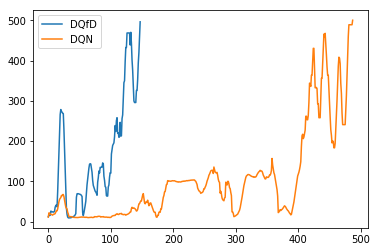

In [8]:
plt.plot(dqfd_return_list,label="DQfD")
plt.plot(dqn_return_list,label="DQN")
plt.legend()
plt.show()